## Introduction

This is a project aimed at predicting the probability of a  user clicking an ad displayed on the website. The dataset contains various features, including timestamp, website ID, browser information, offer ID, etc. pertaining to the advertisements displayed and the users' response. The challenge is to build a classification model that correctly predicts whether a user will click an ad, under various circumstances.

The preprocessing steps that have been followed include :

*   Imputing missing values
*   Encoding categorical variables
*   Feature Engineering


The primary issue with the dataset is that the Target feature is highly skewed with the number of negative samples being almost 100 times the number of positive samples available.We first try conventional approaches using various standard models, with the objective of achieving a high AUC score. The models that have been used include:

*   XGBoost
*   LightGBM
*   Random Forest Classifier



Following this, we follow two other approaches that are tailored to address the specific problem of the skewed dataset.


*   Logistic Regression with a custom cost function and gradient update rule
*   XGBoost with a modified dataset to counter skewness


### Importing necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv') 

We concat the train and test sets for the purpose of preprocessing, and separate them later for training

In [0]:
data = pd.concat([train,test],axis=0) 

In [8]:
data.head()

,ID,browserid,category,click,countrycode,datetime,devid,merchant,offerid,siteid
0,IDsrk7SoW,Firefox,17714,0.0,e,2017-01-14 09:42:09,NaN,20301556,887235,4709696.0
1,IDmMSxHur,Mozilla Firefox,21407,0.0,b,2017-01-18 17:50:53,Desktop,9434818,178235,5189467.0
2,IDVLNN0Ut,Edge,25085,0.0,a,2017-01-11 12:46:49,NaN,2050923,518539,98480.0
3,ID32T6wwQ,Firefox,40339,0.0,c,2017-01-17 10:18:43,Mobile,72089744,390352,8896401.0
4,IDqUShzMg,Mozilla Firefox,12052,0.0,d,2017-01-14 16:02:33,Desktop,39507200,472937,5635120.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15844717 entries, 0 to 3706906
Data columns (total 10 columns):
ID             object
browserid      object
category       int64
click          float64
countrycode    object
datetime       object
devid          object
merchant       int64
offerid        int64
siteid         float64
dtypes: float64(2), int64(3), object(5)
memory usage: 1.3+ GB


## Data Preprocessing

### Managing null values

In [10]:
data.isnull().sum() 

ID                   0
browserid       830233
category             0
click          3706907
countrycode          0
datetime             0
devid          2524918
merchant             0
offerid              0
siteid         1583291
dtype: int64

In [11]:
data['browserid'].value_counts()

Edge                 4463185
Firefox              4327803
Mozilla              1449150
Mozilla Firefox      1304012
InternetExplorer     1019073
Google Chrome         950509
IE                    450078
Chrome                449874
Internet Explorer     300663
Opera                 150193
Safari                149944
Name: browserid, dtype: int64

In [12]:
data['devid'].value_counts()

Mobile     5215690
Tablet     4361636
Desktop    3742473
Name: devid, dtype: int64

#### Impute browserid and devid with mode of the respective columns

In [0]:
data['browserid'].fillna(data['browserid'].mode()[0],inplace=True) 

In [0]:
data['devid'].fillna(data['devid'].mode()[0],inplace=True) 

(array([1358489., 1467781., 1371435., 1518536., 1417569., 1317604.,
        1424025., 1510092., 1445805., 1430090.]),
 array([7.1000000e+01, 1.0000635e+06, 2.0000560e+06, 3.0000485e+06,
        4.0000410e+06, 5.0000335e+06, 6.0000260e+06, 7.0000185e+06,
        8.0000110e+06, 9.0000035e+06, 9.9999960e+06]),
 <a list of 10 Patch objects>)

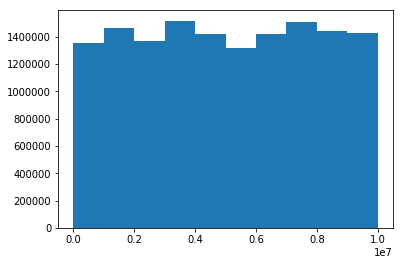

In [11]:
plt.hist(data['siteid'].dropna())

#### The siteid has an almost uniform distribution with no specific trends. So, we impute this column with the mean.

In [0]:
data['siteid'].fillna(data['siteid'].mean(),inplace=True) 
data['countrycode'].fillna(data['countrycode'].mode(),inplace=True)

In [0]:
data.isnull().sum() 

ID                   0
browserid            0
category             0
click          3706907
countrycode          0
datetime             0
devid                0
merchant             0
offerid              0
siteid               0
dtype: int64

(array([2846403., 1886969., 1091373., 1261000., 3615103.,  830065.,
         688758.,  905323., 1377126., 1342597.]),
 array([9.70000e+01, 1.00787e+04, 2.00604e+04, 3.00421e+04, 4.00238e+04,
        5.00055e+04, 5.99872e+04, 6.99689e+04, 7.99506e+04, 8.99323e+04,
        9.99140e+04]),
 <a list of 10 Patch objects>)

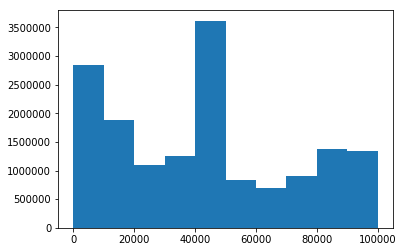

In [16]:
plt.hist(data['category'])

### Encoding categorical variables

In [0]:
from sklearn import preprocessing
encoder=preprocessing.LabelEncoder()
data['browserid']=pd.Series(encoder.fit_transform(data['browserid']))
data['devid']=pd.Series(encoder.fit_transform(data['devid']))
data['countrycode']=pd.Series(encoder.fit_transform(data['countrycode'])) 

In [0]:
data.head()

,ID,browserid,category,click,countrycode,datetime,devid,merchant,offerid,siteid
0,IDsrk7SoW,2,17714,0.0,4,2017-01-14 09:42:09,1,20301556,887235,4709696.0
1,IDmMSxHur,8,21407,0.0,1,2017-01-18 17:50:53,0,9434818,178235,5189467.0
2,IDVLNN0Ut,1,25085,0.0,0,2017-01-11 12:46:49,1,2050923,518539,98480.0
3,ID32T6wwQ,2,40339,0.0,2,2017-01-17 10:18:43,1,72089744,390352,8896401.0
4,IDqUShzMg,8,12052,0.0,3,2017-01-14 16:02:33,0,39507200,472937,5635120.0


#### Extract the day of the week and hour from the datetime column

In [0]:
data['day']=pd.to_datetime(data['datetime']).dt.weekday_name 

In [0]:
data['hour']=pd.to_datetime(data['datetime']).dt.hour

In [0]:
encoder=preprocessing.LabelEncoder()
data['day']=pd.Series(encoder.fit_transform(data['day'])) 

In [0]:
data.head()

,ID,browserid,category,click,countrycode,datetime,devid,merchant,offerid,siteid,day,hour
0,IDsrk7SoW,2,17714,0.0,4,2017-01-14 09:42:09,1,20301556,887235,4709696.0,2,9
1,IDmMSxHur,8,21407,0.0,1,2017-01-18 17:50:53,0,9434818,178235,5189467.0,6,17
2,IDVLNN0Ut,1,25085,0.0,0,2017-01-11 12:46:49,1,2050923,518539,98480.0,6,12
3,ID32T6wwQ,2,40339,0.0,2,2017-01-17 10:18:43,1,72089744,390352,8896401.0,5,10
4,IDqUShzMg,8,12052,0.0,3,2017-01-14 16:02:33,0,39507200,472937,5635120.0,2,16


#### Plot the correlation map to look for dependencies among the features

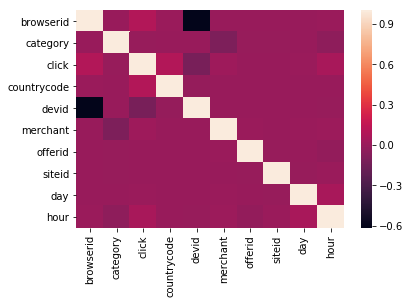

In [0]:
import seaborn as sns
p=data.corr()
sns.heatmap(p)

## Training

In [0]:
needed_cols=['browserid','category','countrycode','devid','merchant','offerid','siteid','day','hour']

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(data[needed_cols].iloc[:train.shape[0]],data['click'].iloc[:train.shape[0]],test_size=0.3,random_state=123)

### Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=5,max_depth=5)
rf.fit(X_train,y_train)

Results of Random Forest Classifier : 
Accuracy = 0.9688881272651326
AUC score = 0.5780117057729955
[[3507437    2324]
 [ 110965   20617]]


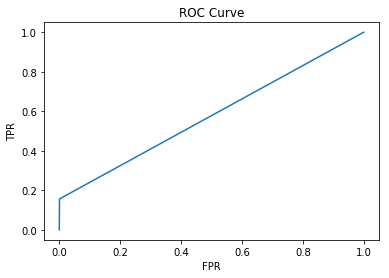

In [43]:
preds_rf = np.round(rf.predict(X_val))
acc_rf=accuracy_score(y_val,preds_rf)  
auc_rf=roc_auc_score(y_val,preds_rf)
print("Results of Random Forest Classifier : ")
print("Accuracy = "+str(acc_rf))
print("AUC score = "+str(auc_rf))
print(confusion_matrix(y_val,preds_rf))
fpr,tpr,_=roc_curve(y_val,preds_rf)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR") 
plt.show() 

### XGBoost

In [0]:
import xgboost as xgb
xg=xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.1,\
                          max_depth = 10, alpha = 0, n_estimators = 10,eval_metric='auc')
xg.fit(X_train,y_train) 

Results of XGBoost with balanced classes : 
Accuracy = 0.9729956776936421
AUC score = 0.6540742123549866
[[3502180    7581]
 [  90751   40831]]


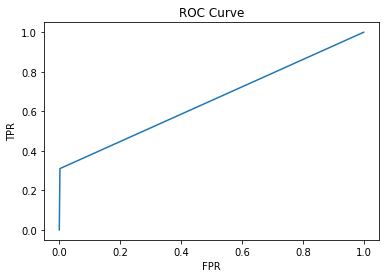

In [0]:
preds_xgb = np.round(xg.predict(X_val))
acc_xgb=accuracy_score(y_val,preds_xgb)  
auc_xgb=roc_auc_score(y_val,preds_xgb)
print("Results of XGBoost with balanced classes : ")
print("Accuracy = "+str(acc_xgb))
print("AUC score = "+str(auc_xgb))
print(confusion_matrix(y_val,preds_xgb))
fpr,tpr,_=roc_curve(y_val,preds_xgb)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR") 
plt.show() 

### LightGBM

In [0]:
import lightgbm as lgb

In [0]:
dtrain = lgb.Dataset(X_train, y_train)
dval = lgb.Dataset(X_val, y_val)

In [0]:
params = {
    
    'num_leaves' : 256,
    'learning_rate':0.03,
    'metric':'auc',
    'objective':'binary',
    'early_stopping_round': 40,
    'max_depth':10,
    'bagging_fraction':0.5,
    'feature_fraction':0.6,
    'bagging_seed':2017,
    'feature_fraction_seed':2017,
    'verbose' : 1   
}

In [0]:
clf = lgb.train(params, dtrain,num_boost_round=200,valid_sets=dval,verbose_eval=20)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 40 rounds.
[20]	valid_0's auc: 0.967775
[40]	valid_0's auc: 0.969927
[60]	valid_0's auc: 0.971411
[80]	valid_0's auc: 0.971772
[100]	valid_0's auc: 0.972145
[120]	valid_0's auc: 0.972339
[140]	valid_0's auc: 0.972555
[160]	valid_0's auc: 0.972785
[180]	valid_0's auc: 0.972963
[200]	valid_0's auc: 0.973135
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.973135


In [0]:
from sklearn.metrics import accuracy_score,f1_score,roc_curve,roc_auc_score,confusion_matrix
preds_lgb = np.round(clf.predict(X_val))
acc_lgb=accuracy_score(y_val,preds_lgb)  

Results of LightGBM : 
Accuracy = 0.9789418354711434
AUC score = 0.7853012411180909
[[3488796   20965]
 [  55715   75867]]


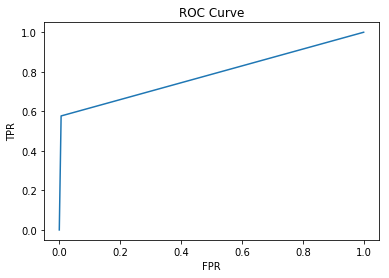

In [0]:
auc_lgb=roc_auc_score(y_val,preds_lgb)
print("Results of LightGBM : ")
print("Accuracy = "+str(acc_lgb))
print("AUC score = "+str(auc_lgb))
print(confusion_matrix(y_val,preds_lgb))
fpr,tpr,_=roc_curve(y_val,preds_lgb)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR") 
plt.show() 

## Improving AUC Score for skewed classes

### Logistic Regression with weighted cost function
We implement logistic regression with a modified cost function and gradient update rule. We penalize the algorithm by a larger amount for predicting samples of the rare class wrongly.



In [0]:
class Log_Regression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-1000*y * np.log(0.001+h) - (1 - y) * np.log(1.001 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            #gradient = np.dot(X.T, (h - y)) / y.size
            gradient=-1000*np.dot(X.T,(1-h)*y)+np.dot(X.T,(1-y)*h)
            self.theta -= self.lr * gradient
        
            if(i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print(f'loss: {self.__loss(h, y)} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [21]:
model = Log_Regression(lr=0.1, num_iter=800)
model.fit(X_train, y_train) 

loss: 6.623318188639904 	


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [0]:
preds_lr_modd = model.predict(X_val,threshold=0.5)  
preds_lr_modd = (preds_lr_modd==0).astype(int)

In [25]:
preds_lr_modd

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
acc_lnew=accuracy_score(y_val,preds_lr_modd)  
auc_lnew=roc_auc_score(y_val,preds_lr_modd)
print(acc_lnew,auc_lnew)

0.9638644313375587 0.5


Though the accuracy is high, the AUC score is poor, which is a clear case ofoverfitting. We solve this issue in the next attempt.

### XGBoost with balanced dataset
We see that improving the AUC score of the model with a skewed dataset is not easy. Therefore, we create a dataset with equal number of positive and negative samples by undersampling the available dataset and feed it to the XGBoost algorithm.



In [0]:
data_mod = data[data['click']==1]
data_mod=pd.concat([data[data['click']==0][:437214],data_mod],axis=0)
X_train,X_val,y_train,y_val=train_test_split(data_mod[needed_cols],data_mod['click'],test_size=0.3,random_state=123) 

In [0]:
import xgboost as xgb
xg=xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.1,\
                          max_depth = 10, alpha = 0, n_estimators = 10,eval_metric='auc')
xg.fit(X_train,y_train)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Results of XGBoost with balanced classes : 
Accuracy = 0.825619737047753
AUC score = 0.826222561705724
[[129617   1070]
 [ 44675  86967]]


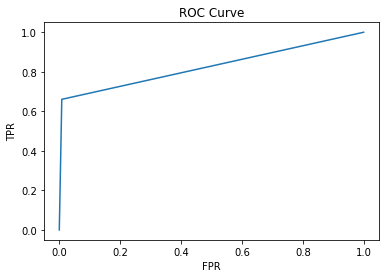

In [0]:
preds_xgb = np.round(xg.predict(X_val))
acc_xgb=accuracy_score(y_val,preds_xgb)  
auc_xgb=roc_auc_score(y_val,preds_xgb)
print("Results of XGBoost with balanced classes : ")
print("Accuracy = "+str(acc_xgb))
print("AUC score = "+str(auc_xgb))
print(confusion_matrix(y_val,preds_xgb))
fpr,tpr,_=roc_curve(y_val,preds_xgb)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR") 
plt.show() 

### Improving accuracy on our XGBoost model
Now, we use twice the number of positive samples as negative samples, to improve the accuracy. Since the ratio of positive to negative samples is just 2:1, we can consider the data to not be too skewed.

In [0]:
data_mod = data[data['click']==1]
data_mod=pd.concat([data[data['click']==0][:437214*2],data_mod],axis=0)
X_train,X_val,y_train,y_val=train_test_split(data_mod[needed_cols],data_mod['click'],test_size=0.3,random_state=123)  

In [34]:
import xgboost as xgb
xg=xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.1,\
                          max_depth = 10, alpha = 0, n_estimators = 10,eval_metric='auc')
xg.fit(X_train,y_train)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Results of XGBoost with balanced classes : 
Accuracy = 0.9108827857166455
AUC score = 0.8894806357762766
[[250117  12122]
 [ 22945 108309]]


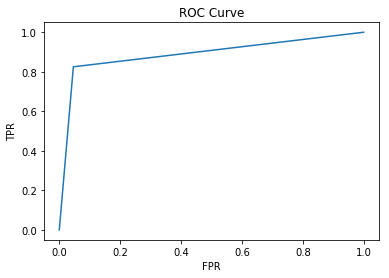

In [37]:
preds_xgb = np.round(xg.predict(X_val))
acc_xgb=accuracy_score(y_val,preds_xgb)  
auc_xgb=roc_auc_score(y_val,preds_xgb)
print("Results of XGBoost with balanced classes : ")
print("Accuracy = "+str(acc_xgb))
print("AUC score = "+str(auc_xgb))
print(confusion_matrix(y_val,preds_xgb))
fpr,tpr,_=roc_curve(y_val,preds_xgb)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR") 
plt.show()   

In [38]:
print("Percentage of the available dataset that was used for this model = {}%".format(str(data_mod.shape[0]/train.shape[0]*100))) 

Percentage of the available dataset that was used for this model = 10.80624923276934%


## Conclusion

We notice improvements in both the accuracy and AUC scores in this final model. Note that we have used only about 11% of the available data to arrive at these results. This indicates that the data required to capture the relevant trends is actually much less than the amount availed. It is more important that the model is trained on a balanced dataset, so that a high AUC score is ensured.

Other attempts that were made include using a weighted loss function for Logistic Regression and Linear Regression, but these did not produce good AUC scores.